## Loading Kaggle Dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pkdarabi/bone-break-classification-image-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'bone-break-classification-image-dataset' dataset.
Path to dataset files: /kaggle/input/bone-break-classification-image-dataset


In [ ]:
import shutil
from pathlib import Path

dest = Path("./data/bone-break")  # your project path
dest.mkdir(parents=True, exist_ok=True)
for item in Path(path).iterdir():
    tgt = dest / item.name
    if item.is_dir():
        shutil.copytree(item, tgt, dirs_exist_ok=True)
    else:
        shutil.copy2(item, tgt)
print("Copied to:", dest)

Copied to: data/bone-break


In [ ]:
!pwd

/content


In [ ]:
from pathlib import Path
import json

# === Point this to the folder that CONTAINS all class folders ===
CWD = Path.cwd()  # '/content' in Colab
ROOT = CWD / "data" / "bone-break" / "Bone Break Classification" / "Bone Break Classification"

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".gif"}

def has_images(p: Path) -> bool:
    if not p.exists() or not p.is_dir():
        return False
    for q in p.rglob("*"):
        if q.is_file() and q.suffix.lower() in IMG_EXTS:
            return True
    return False

def derive_class_dirs(root: Path):
    """
    Return a sorted list of (class_name, class_dir) pairs.
    class_dir is the top-level folder representing the class.
    """
    class_pairs = []
    for child in sorted([d for d in root.iterdir() if d.is_dir()], key=lambda x: x.name.lower()):
        # Case 1: images are directly inside the child directory
        if has_images(child):
            class_pairs.append((child.name, child))
            continue

        # Case 2: images live under a Train/train folder inside the child
        train_dir = None
        for name in ("Train", "train"):
            cand = child / name
            if cand.is_dir() and has_images(cand):
                train_dir = cand
                break
        if train_dir is not None:
            class_pairs.append((child.name, child))

    # sanity check
    if not class_pairs:
        raise RuntimeError(f"No class folders with images found under: {root.resolve()}")

    return class_pairs

# ---- Run & summarize ----
class_dirs = derive_class_dirs(ROOT)
class_names = [name for name, _ in class_dirs]
class_to_idx = {name: i for i, name in enumerate(class_names)}

print("Discovered classes:")
for i, name in enumerate(class_names):
    print(f"[{i}] {name}")

# Optional: save mapping for later use
OUT = ROOT / "class_to_idx.json"
with OUT.open("w") as f:
    json.dump(class_to_idx, f, indent=2)
print(f"\nSaved class_to_idx to: {OUT}")

classes = sorted(class_names)

Discovered classes:
[0] Avulsion fracture
[1] Comminuted fracture
[2] Fracture Dislocation
[3] Greenstick fracture
[4] Hairline Fracture
[5] Impacted fracture
[6] Longitudinal fracture
[7] Oblique fracture
[8] Pathological fracture
[9] Spiral Fracture

Saved class_to_idx to: /content/data/bone-break/Bone Break Classification/Bone Break Classification/class_to_idx.json


## Setup

In [ ]:
!git clone https://github.com/0raiser0/PH-Reg.git

Cloning into 'PH-Reg'...
remote: Enumerating objects: 264, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 264 (delta 7), reused 2 (delta 1), pack-reused 255 (from 2)
Receiving objects: 100% (264/264), 23.33 MiB | 20.03 MiB/s, done.
Resolving deltas: 100% (64/64), done.


In [ ]:
!pip install ftfy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.4 MB/s eta 0:00:00


In [ ]:
!ls /content/PH-Reg

demo_tutorial.ipynb  images   models	 requirements_eval.txt
DINOv2_full	     LICENSE  README.md


In [ ]:
# If not already in the PH-Reg root:
# %cd /PH-Reg  # adjust if your workspace root is different

!pip install -q gdown

# Download the distilled CLIP weights from Google Drive
!gdown --id 11DtEHvpFWVA3nM1rYLOtJ4XUxH19MsSl -O /content/PH-Reg/models/OpenaiMaskCLIP/phreg_vitb16.pt

# Check that it’s there
!ls -lh /content/PH-Reg/models/OpenaiMaskCLIP

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=11DtEHvpFWVA3nM1rYLOtJ4XUxH19MsSl
From (redirected): https://drive.google.com/uc?id=11DtEHvpFWVA3nM1rYLOtJ4XUxH19MsSl&confirm=t&uuid=762ab340-16bb-41a6-ae74-e0af93651c71
To: /content/PH-Reg/models/OpenaiMaskCLIP/phreg_vitb16.pt
100% 347M/347M [00:04<00:00, 74.5MB/s]
total 332M
-rw-r--r-- 1 root root 1.3M Nov 15 05:38 bpe_simple_vocab_16e6.txt.gz
-rw-r--r-- 1 root root 8.4K Nov 15 05:38 clip.py
-rw-r--r-- 1 root root  12K Nov 15 05:38 clip_reg_bk.py
-rw-r--r-- 1 root root  15K Nov 15 05:38 clip_reg.py
-rw-r--r-- 1 root root    0 Nov 15 05:38 __init__.py
-rw-r--r-- 1 root root  18K Nov 15 05:38 model.py
-rw-r--r-- 1 root root 331M Oct 19 09:39 phreg_vitb16.pt
drwxr-xr-x 2 root root 4.0K Nov 15 05:45 __pycache

## Data Preperation

In [ ]:
import os, json, random
from pathlib import Path

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import torchvision.transforms as T
import timm  # pip install timm if needed

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
def collect_items(class_dirs, split_name="Train"):
    """
    Collect (path, label_idx) pairs from split_name ('Train' or 'Test') folders.
    """
    items = []
    for class_name, class_dir in class_dirs:
        label = class_to_idx[class_name]

        split_dir = None
        for name in (split_name, split_name.lower()):
            cand = class_dir / name
            if cand.is_dir() and has_images(cand):
                split_dir = cand
                break

        if split_dir is None:
            # No such split for this class; skip it
            continue

        for p in split_dir.rglob("*"):
            if p.is_file() and p.suffix.lower() in IMG_EXTS:
                items.append((p, label))

    return items

# Use Train/ for training + validation
train_all_items = collect_items(class_dirs, split_name="Train")
print("Total Train images (before split):", len(train_all_items))

# Simple train/val split
random.seed(42)
random.shuffle(train_all_items)

val_frac = 0.2  # 20% for validation; tweak as you like
n_total = len(train_all_items)
n_val   = int(n_total * val_frac)
n_train = n_total - n_val

val_items   = train_all_items[:n_val]
train_items = train_all_items[n_val:]

print(f"Train images: {len(train_items)}")
print(f"Val images:   {len(val_items)}")

# Optional: Test set (from Test/ folders)
test_items = collect_items(class_dirs, split_name="Test")
print("Test images:", len(test_items))

Total Train images (before split): 989
Train images: 792
Val images:   197
Test images: 140


In [ ]:
# Standard ImageNet-style transforms for ViT
img_size = 224

train_tfms = T.Compose([
    T.Resize((img_size, img_size)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
])

val_tfms = T.Compose([
    T.Resize((img_size, img_size)),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
])

class BoneBreakDataset(Dataset):
    def __init__(self, items, transform=None):
        """
        items: list of (Path, label_idx)
        """
        self.items = items
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        path, label = self.items[idx]
        img = Image.open(path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img, label

train_ds = BoneBreakDataset(train_items, transform=train_tfms)
val_ds   = BoneBreakDataset(val_items,   transform=val_tfms)
test_ds  = BoneBreakDataset(test_items,  transform=val_tfms) if len(test_items) > 0 else None

len(train_ds), len(val_ds), len(test_ds) if test_ds is not None else None

(792, 197, 140)

## Model

In [ ]:
%cd /content/PH-Reg

import os
print("Now CWD =", os.getcwd())

/content/PH-Reg
Now CWD = /content/PH-Reg


In [ ]:
import os, sys
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
assert torch.cuda.is_available()

In [ ]:
# Set hyperparamters for an image
img_path = '/content/data/bone-break/Bone Break Classification/Bone Break Classification/Greenstick fracture/Test/40926tn_jpg.rf.95b23c6c30cc0d022f5af322fe72b9ce.jpg'
resolution = 448
patch_size = 16
num_patches = resolution // patch_size
pretrained_path = 'ViT-B/16' # The path of your OpenAI CLIP pretrianed weight or 'ViT-B/16'
distilled_path = "models/OpenaiMaskCLIP/phreg_vitb16.pt"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_registers = 16

# Set hyperparameters for denoising process
shift_ratio = 0.15
counts = 10
num_registers = 16
vis_shifted_img = True

In [ ]:
# Initialize NACLIP
import torch.nn.functional as F
import math
def upsampling_pos_embedding(old_patch_pos_embed, patch_size, input_resolution):

    # ------------------------------------------------------------
    # 2.2 Upscale the positional embeddings from 224×224 -> 448x448
    #     (224/16=14 patches → 448/16=28 patches)
    # ------------------------------------------------------------
    # shape: (1 + 14×14, 768)
    if input_resolution == (224, 224):
        return old_patch_pos_embed

    # The first token is [CLS], next tokens are patch embeddings
    patch_pos_embed = old_patch_pos_embed[1:]  # shape: (14×14, 768)
    # print(patch_pos_embed.shape)
    num_patches, hidden_size = patch_pos_embed.shape
    patches = int(math.sqrt(num_patches))
    assert patches ** 2 == num_patches
    # Reshape to (1, 14, 14, 768) => permute => interpolate => (1, 28, 28, 768)
    patch_pos_embed_2d = patch_pos_embed.reshape(-1, patches, patches, hidden_size).permute(0, 3, 1, 2)
    # print(f"patch_pos_embed_2d: {patch_pos_embed_2d.shape}")

    # The input images might not be a square when conducting segmentation.
    patch_pos_embed_v2 = F.interpolate(
        patch_pos_embed_2d,
        size=(input_resolution // patch_size, input_resolution // patch_size),
        mode='bicubic',
        align_corners=False,
        recompute_scale_factor=False
    )

    # Flatten back to (28×28, 768)
    flat = patch_pos_embed_v2.permute(0, 2, 3, 1).view(1, -1, hidden_size)
    # print(f"flat: {flat.shape}")
    # Recombine with the [CLS] token
    positional_embedding = torch.cat([old_patch_pos_embed[:1], flat[0]], dim=0)

    return positional_embedding

# Initialize Open AI ViT-B/16
from models.NACLIP.clip import load

clip_model, _ = load(
    name=pretrained_path,
    device=device,
    jit=False
)
clip_model = clip_model.to(dtype=torch.float32)
clip_model.visual.set_params(arch='reduced', attn_strategy='naclip', gaussian_std=5.0)
# Update positional embedding
old_pos_embed = torch.clone(clip_model.visual.positional_embedding.detach())
clip_model.visual.positional_embedding.data = upsampling_pos_embedding(
    old_patch_pos_embed=old_pos_embed,
    patch_size=patch_size,
    input_resolution=resolution
)
clip_model.eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [ ]:
# Initialize distilled model
from models.OpenaiMaskCLIP.clip_reg import student_model_initialization

# Initialize student model
distilled_model, _ = student_model_initialization(
    pretrained=pretrained_path,
    num_register_tokens=num_registers,
    patch_size=patch_size,
    input_resolution=(resolution, resolution),
    pos_grad=False
)

distilled_model = distilled_model.to(torch.float32)
distilled_model.load_state_dict(torch.load(distilled_path))
distilled_model = distilled_model.to(device)

We are fine-tuning Position Embedding, 16 Registers, Conv Layer and Transformer Resblocks[-1],[-2]


In [ ]:
# umap
import numba
import umap

def feature_umap(patch_feats, num_patches):
    assert len(patch_feats.shape) ==  2
    patch_feats = patch_feats / patch_feats.norm(dim=-1, keepdim=True)
    patch_feats_np = patch_feats.detach().cpu().numpy()

    @numba.njit()
    def mydist(in1, in2):
        return np.arccos(np.sum(in1*in2))

    transformer = umap.UMAP(
        n_components=3,
        metric=mydist)
    embedding = transformer.fit_transform(patch_feats_np)

    embedding_map = embedding.reshape(num_patches, num_patches, 3)

    normalized_map = np.zeros_like(embedding_map)
    for c in range(3):
        channel = embedding_map[:, :, c]
        c_min = channel.min()
        c_max = channel.max()
        normalized_map[:, :, c] = (channel - c_min) / (c_max - c_min + 1e-8)
    embedding_map = normalized_map

    embedding_tensor = torch.tensor(embedding_map, dtype=torch.float32).permute(2, 0, 1)  # [1, H, W]

    embedding_up = F.interpolate(embedding_tensor.unsqueeze(0), size=resolution, mode='nearest')
    embedding_up = embedding_up.squeeze()  # [n_comp, H, W]

    if embedding_up.shape[-1] != 3:
        embedding_up = embedding_up[:3, :, :] # :3, :, :
        embedding_up = embedding_up.permute(1, 2, 0)
    embedding_up = embedding_up.numpy()

    return embedding_up


from models.NACLIP.clip import tokenize

def generate_heatmap(image_embedding, text_embedding, num_patches, resolution):
    image_embedding = image_embedding.to(torch.float32)
    text_embedding = text_embedding.to(torch.float32)

    image_embedding_norm = image_embedding / image_embedding.norm(dim=-1, keepdim=True)
    text_embedding_norm = text_embedding / text_embedding.norm(dim=-1, keepdim=True)
    text_embedding_expanded = text_embedding_norm.unsqueeze(1)

    heatmaps = torch.bmm(image_embedding_norm, text_embedding_expanded.transpose(1, 2))
    heatmaps = heatmaps.squeeze(-1).reshape(1, num_patches, num_patches)
    heatmaps = heatmaps.cpu().unsqueeze(0)
    heatmaps = F.interpolate(heatmaps, size=(resolution, resolution), mode='nearest')
    heatmaps = heatmaps.squeeze(0).permute(1, 2, 0).numpy()

    return heatmaps

In [ ]:
# Feedforward Pass
from torchvision.transforms import transforms
import requests
from PIL import Image

# ori_img = Image.open(requests.get(url=img_path, stream=True).raw)
# If you are using your own image
ori_img = Image.open(img_path)

img_transform = transforms.Compose([
                            transforms.Resize(resolution, interpolation=transforms.InterpolationMode.BICUBIC),
                            transforms.CenterCrop(resolution),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                            std=[0.26862954, 0.26130258, 0.27577711]),
                            ])

tensor_img = img_transform(ori_img)

tensor_img = tensor_img.unsqueeze(0).to(device)

with torch.inference_mode():
    naclip_dense = clip_model.visual(tensor_img, return_all=True).detach()
    # Drop CLS token
    naclip_dense = naclip_dense[:, 1:, :]
    print(naclip_dense.shape)

    clean_dense = distilled_model(tensor_img).detach()
    # Drop CLS token and register tokens
    clean_dense = clean_dense[:, 1:-num_registers, :]
    print(clean_dense.shape)

# Get Umap
naclip_feat_umap = feature_umap(naclip_dense[0], num_patches)

clean_feat_umap = feature_umap(clean_dense[0], num_patches)
# print(clean_feat_umap.shape)

texts = []
prompt = 'an xray photo of Avulsion fracture'
texts.append(prompt)

text_input = tokenize(texts).to(device)
with torch.no_grad():
    text_features = clip_model.encode_text(text_input).detach()


# Get Heatmap
naclip_heatmap = generate_heatmap(naclip_dense, text_features, num_patches, resolution)
clean_heatmap = generate_heatmap(clean_dense, text_features, num_patches, resolution)

torch.Size([1, 784, 512])
torch.Size([1, 784, 512])


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1857: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1857: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


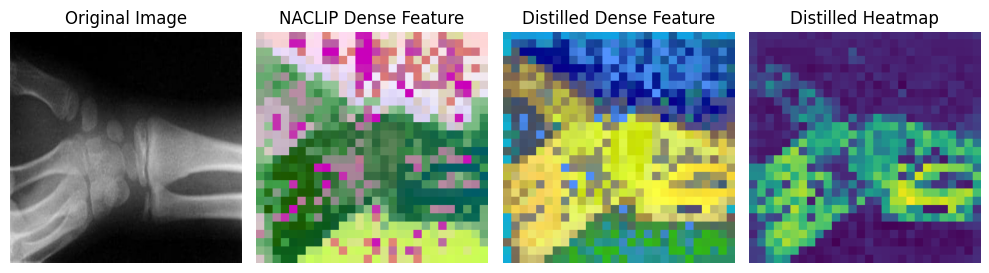

In [ ]:
# Visualize all heatmaps using text as prompt
vis_transform = transforms.Compose([
                            transforms.Resize(resolution, interpolation=transforms.InterpolationMode.BICUBIC),
                            transforms.CenterCrop(resolution),
                            ])
vis_img = vis_transform(ori_img)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 60))
axes = axes.flatten()

axes[0].imshow(vis_img)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(naclip_feat_umap)
axes[1].set_title("NACLIP Dense Feature")
axes[1].axis('off')

# axes[2].imshow(naclip_heatmap)
# axes[2].set_title("NACLIP Heatmap")
# axes[2].axis('off')

axes[2].imshow(clean_feat_umap)
axes[2].set_title("Distilled Dense Feature")
axes[2].axis('off')

axes[3].imshow(clean_heatmap)
axes[3].set_title("Distilled Heatmap")
axes[3].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def prepare_patch_idxs(num_patches):
    patch_idxs = torch.stack(
        torch.meshgrid(
            torch.arange(num_patches, dtype=torch.int32),
            torch.arange(num_patches, dtype=torch.int32),
            indexing='ij'
        ),
        dim=0
    ) # shape: (2, num_patches, num_patches)
    # We'll store as (B, 2, num_patches, num_patches) after broadcasting

    return patch_idxs

In [ ]:
num_patches = resolution // patch_size
patch_idxs = prepare_patch_idxs(num_patches=num_patches)
# print(patch_idxs)
# print(patch_idxs.shape)

In [ ]:
def prepare_flip(counts, seed):
    rng = np.random.default_rng(seed=seed)
    flip = rng.integers(0, 2, counts)
    flip[0] = 0

    return flip

In [ ]:
flip = prepare_flip(
    counts=counts,
    seed=random.randint(1,999999999)
)
# The first augmented image should be the image itself.
flip[0] = 0
# print(flip)
# print(flip.shape)

In [ ]:
def prepare_all_offsets(num_patches, shift_frac=0.15, counts=10, seed=42) -> torch.Tensor:
    # num_patches = int(input_resolution // patch_size)
    # assert input_resolution == int(num_patches * patch_size)
    # how many patches we can shift
    shift_patch = int(round(shift_frac * num_patches))
    rng = np.random.default_rng(seed=seed)

    # We'll draw a large pool of offsets (x,y) from [-shift_patch, shift_patch]
    rand_x = rng.integers(-shift_patch, shift_patch, size=counts*10, endpoint=True)
    rand_y = rng.integers(-shift_patch, shift_patch, size=counts*10, endpoint=True)
    all_offsets = np.stack([rand_x, rand_y], axis=1)[None] # [None] to expand 1 dim
    # shape: (1, counts*10, 2)

    all_offsets_torch = torch.from_numpy(all_offsets).float()

    return all_offsets_torch

In [ ]:
all_offsets_torch = prepare_all_offsets(
    num_patches=num_patches,
    shift_frac=shift_ratio,
    counts=counts,
    seed=random.randint(1,999999999)
)
# print(all_offsets_torch)
# print(all_offsets_torch.shape)

In [ ]:
def farthest_point_sample(all_offsets, num_sample, seed) -> torch.Tensor:
    """
    Given a set of XY points [1, N, 2] (all_offsets), selects 'num_sample' points using farthest point sampling.
    This is basically the same approach from your script.
    """
    device = all_offsets.device
    B, N, C = all_offsets.shape

    # center points, used to compute the Euclidean distance from reference offset points.
    centroids = torch.zeros(size=(B, num_sample), dtype=torch.long, device=device)
    # represents the Euclidean distance between centroids and offset points
    distance = torch.full(size=(B, N), fill_value=float('inf'), device=device)
    # the farthest point index, just one value
    torch.manual_seed(seed)
    farthest = torch.randint(low=0, high=N, size=(B,), dtype=torch.long, device=device)
    #  tensor([0])
    batch_indices = torch.arange(end=B, dtype=torch.long, device=device)

    for i in range(num_sample):
        # give the farthest point index to 'centroids'
        centroids[:, i] = farthest
        # select a center point
        center = all_offsets[batch_indices, farthest, :].view(B, 1, 2)
        # compute distance between center point and each offset point in the pair
        dist = torch.sum((all_offsets - center) ** 2, dim=-1)
        mask = dist < distance
        distance[mask] = dist[mask]
        # return the index of the farthest point, using [1] to select index
        farthest = torch.max(distance, dim=-1)[1]

    return centroids

In [ ]:
selected_idx = farthest_point_sample(
    all_offsets=all_offsets_torch,
    num_sample=counts,
    seed=random.randint(1,999999999)
)

selected_offsets = all_offsets_torch[0, selected_idx[0], :].numpy().astype(np.int32)
# The first augmented image should be the image itself.
selected_offsets[0] = [0, 0]
# print(selected_offsets)
# print(selected_offsets.shape)

In [ ]:
def shuffle_shift(input_tensor, offset_height, offset_width, infill=-100.0):
    """
    Shifts the tensor spatially by (offset_height, offset_width).
    Any area that goes 'out of bounds' is filled by 'infill'.
    input_tensor has shape (B, C, H, W).
    """
    C, H, W = input_tensor.shape

    """
    We want the region that remains after shifting:
    If 'offset_height' > 0, we are shifting 'upwards', so the bottom rows become infill.
    Construct slices carefully in PyTorch.
    We'll do it by indexing and then padding.
    For positive 'offset_height', we shift forward in the H dimension. Negative means shift backward, etc.
    """
    """
    If 'offset_height' < 0, we cut the image from 0 to H + offset_height.
    Similarly, when 'offset_width' < 0
    Then the image are shifted downwards.
    """
    # Original Height: 0 -> H from top to down
    # Similar to Original Width
    low_height = max(0, offset_height)
    up_height = min(H, H + offset_height)
    low_width = max(0, offset_width)
    up_width = min(W, W + offset_width)

    # Slicing region that remains after shifting
    src_height = slice(low_height, up_height)
    src_width = slice(low_width, up_width)

    dst_height = slice(low_height - offset_height, up_height - offset_height)
    dst_width = slice(low_width - offset_width, up_width - offset_width)

    # Create an output tensor of the same size, filled with infill
    out = torch.full_like(input_tensor, fill_value=infill)

    # Copy the valid region over
    out[:, dst_height, dst_width] = input_tensor[:, src_height, src_width]
    "Maybe we can update infill value here."
    return out

In [ ]:
# Apply augmentations to the Image
from torchvision.transforms import transforms

img_transform = transforms.Compose([
                            transforms.Resize(resolution, interpolation=transforms.InterpolationMode.BICUBIC),
                            transforms.CenterCrop(resolution),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                            std=[0.26862954, 0.26130258, 0.27577711]),
                            ])

tensor_img = img_transform(ori_img)

# Start shifting
shifted_imgs = []
shifted_idxs_sets = []
for offset_i in range(counts):
    # Get offset coordinate
    offset_height, offset_width = selected_offsets[offset_i]
    # Get filp, 0: no flip, 1: do flip
    do_flip = flip[offset_i]

    shifted_img = shuffle_shift(
        input_tensor=tensor_img,
        offset_height=offset_height * patch_size,
        offset_width = offset_width * patch_size,
        infill=-100
    )

    if do_flip == 1:
        # flip along horizontal dim
        shifted_img = torch.flip(shifted_img, dims=[2])

    # Fix out-of-bounds fill => set them to large values that match CLIP's high distribution
    replace_values = torch.tensor([1.93033625, 2.07488384, 2.14589699], device=shifted_img.device)
    shifted_img = torch.where(shifted_img<-50, replace_values.view(3, 1, 1), shifted_img)

    shifted_imgs.append(shifted_img)

    # Get shifted patch positions
    shifted_idxs = shuffle_shift(
        input_tensor=patch_idxs,
        offset_height=offset_height,
        offset_width=offset_width,
        infill=-1
    ) # [2, num_patches, num_patches]
    if do_flip == 1:
        shifted_idxs = torch.flip(shifted_idxs, dims=[2])

    shifted_idxs_sets.append(shifted_idxs)

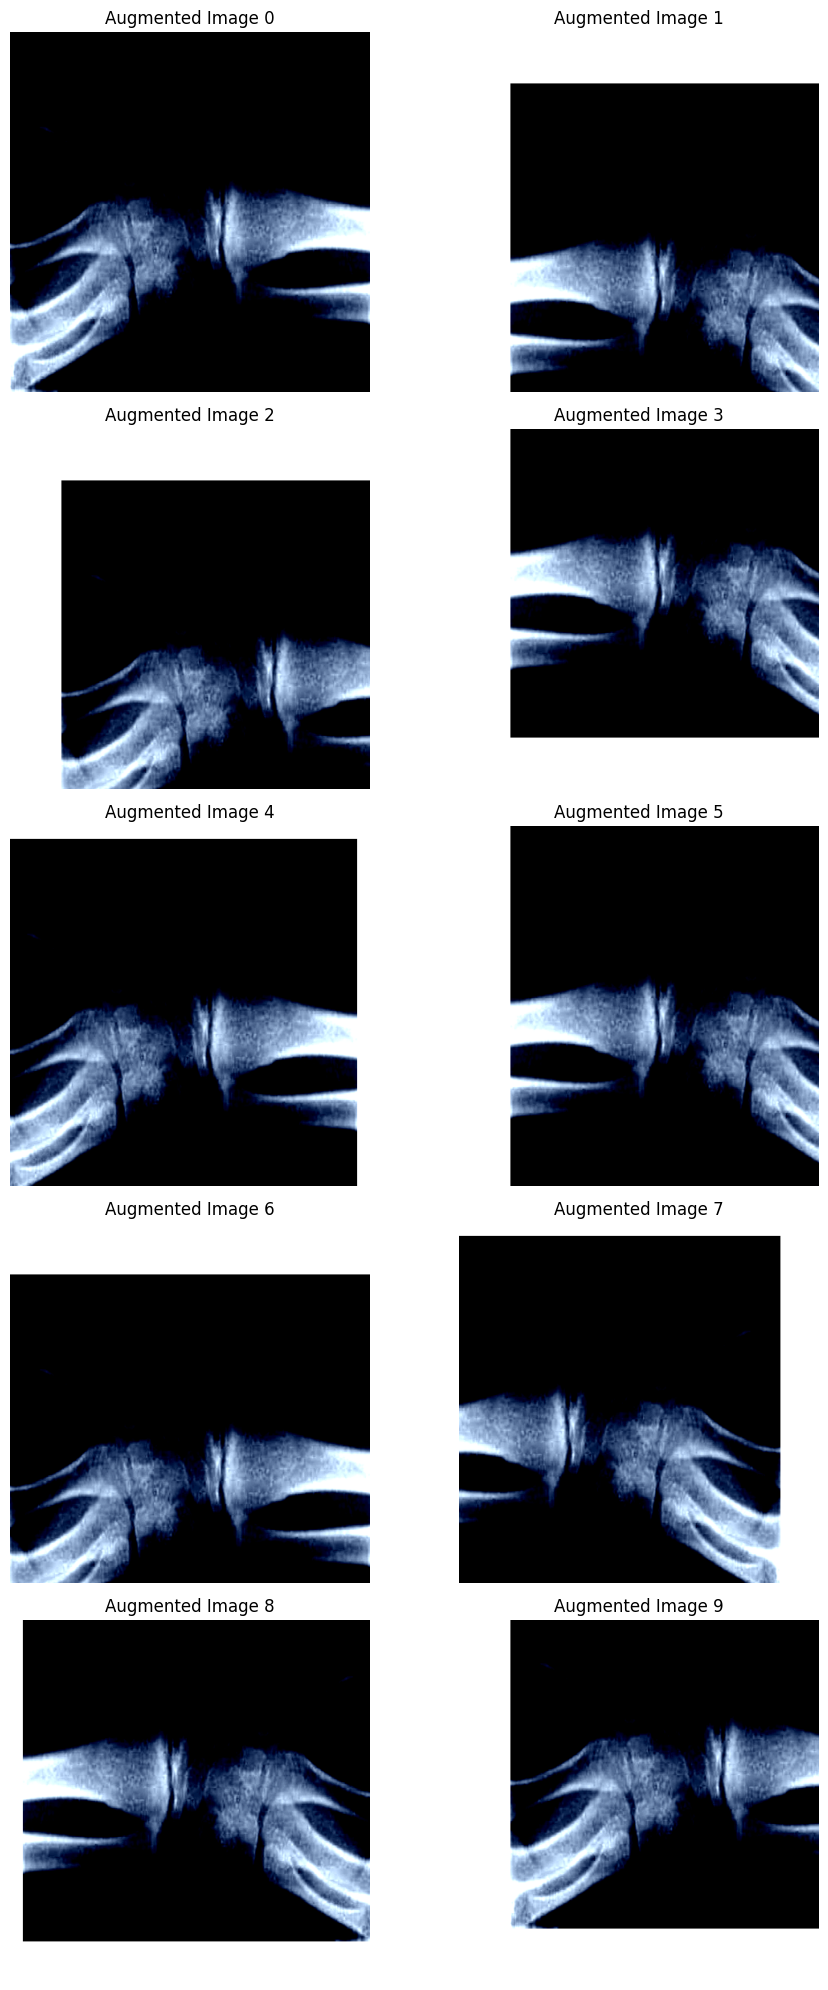

In [ ]:
if vis_shifted_img:
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))
    axes = axes.flatten()

    for i, img in enumerate(shifted_imgs):
        axes[i].imshow(img.permute(1, 2, 0).numpy())
        axes[i].set_title(f"Augmented Image {i}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# change shifted_imgs, shifted_idx to Tensor
out_shifted_imgs = torch.stack(shifted_imgs, dim=0).unsqueeze(0)
out_shifted_idxs_sets = torch.stack(shifted_idxs_sets, dim=0).unsqueeze(0)
# print(out_shifted_imgs.shape)
# print(out_shifted_idxs_sets.shape)

assert len(out_shifted_imgs.shape) == 5

In [ ]:
import torch.nn.functional as F
import math
def upsampling_pos_embedding(old_patch_pos_embed, patch_size, input_resolution):

    # ------------------------------------------------------------
    # 2.2 Upscale the positional embeddings from 224×224 -> 448x448
    #     (224/16=14 patches → 448/16=28 patches)
    # ------------------------------------------------------------
    # shape: (1 + 14×14, 768)
    if input_resolution == (224, 224):
        return old_patch_pos_embed

    # The first token is [CLS], next tokens are patch embeddings
    patch_pos_embed = old_patch_pos_embed[1:]  # shape: (14×14, 768)
    # print(patch_pos_embed.shape)
    num_patches, hidden_size = patch_pos_embed.shape
    patches = int(math.sqrt(num_patches))
    assert patches ** 2 == num_patches
    # Reshape to (1, 14, 14, 768) => permute => interpolate => (1, 28, 28, 768)
    patch_pos_embed_2d = patch_pos_embed.reshape(-1, patches, patches, hidden_size).permute(0, 3, 1, 2)
    # print(f"patch_pos_embed_2d: {patch_pos_embed_2d.shape}")

    # The input images might not be a square when conducting segmentation.
    patch_pos_embed_v2 = F.interpolate(
        patch_pos_embed_2d,
        size=(input_resolution // patch_size, input_resolution // patch_size),
        mode='bicubic',
        align_corners=False,
        recompute_scale_factor=False
    )

    # Flatten back to (28×28, 768)
    flat = patch_pos_embed_v2.permute(0, 2, 3, 1).view(1, -1, hidden_size)
    # print(f"flat: {flat.shape}")
    # Recombine with the [CLS] token
    positional_embedding = torch.cat([old_patch_pos_embed[:1], flat[0]], dim=0)

    return positional_embedding

In [ ]:
out_shifted_imgs = out_shifted_imgs.to(device)
out_shifted_idxs_sets = out_shifted_idxs_sets.to(device)

with torch.no_grad():
    "original dense features"
    # print(out_shifted_imgs[:, 0].shape)
    original_dense = clip_model.visual(out_shifted_imgs[:, 0], return_all=True)[:, 1:, :]
    # drop the CLS token
    # print(original_dense.shape)

    "denoised dense features"
    shifted_images = out_shifted_imgs.reshape(-1, 3, resolution, resolution)
    shifted_idxs = out_shifted_idxs_sets.reshape(-1, 2, num_patches, num_patches)
    original_img_feats = clip_model.visual(shifted_images, return_all=True)
    original_img_feats = original_img_feats[:, 1:, :]
    out_hidden_size = original_img_feats.shape[-1]
    original_img_feats = original_img_feats.reshape(-1, num_patches, num_patches, out_hidden_size)

    # move images back to their original position
    B = original_img_feats.shape[0]
    final_maps_zero = torch.zeros_like(
        input=original_img_feats,
        dtype=original_img_feats.dtype,
        device=original_img_feats.device
    )

    contribution_map_zero = torch.zeros(
        size=(B, num_patches, num_patches),
        dtype=original_img_feats.dtype,
        device=original_img_feats.device
    )

    # Get valid shifting postion, valid_mask: (B, H, W)
    valid_mask = (shifted_idxs >= 0).all(dim=1)

    # Get indexes of all valid shifting postions
    batch_idx, valid_h, valid_w = valid_mask.nonzero(as_tuple=True)
    # size: batch_size * num_patches * num_patches

    # According to valid postion indexes，we can get shifting positions
    # shifted_idxs: (B, 2, H, W)，x_coords: shifted_idxs[b, 0, h, w]
    # y_coords: shifted_idxs[b, 1, h, w]
    x_coords = shifted_idxs[batch_idx, 0, valid_h, valid_w]
    y_coords = shifted_idxs[batch_idx, 1, valid_h, valid_w]

    # Extract valid patches from patch_feats_2d (B, H, W, hidden_size)
    patch_feats_valid = original_img_feats[batch_idx, valid_h, valid_w]
    # shape: (B, h, w, hidden_size)

    # Accumalate to corresponding positions in final_maps (B, H, W, hidden_size)
    # x_coords, y_coords correspond to the second, third dimension in final_maps, respectively
    # We select all values along the hidden_size(fourth) dimension. So we not show it in the code.
    # final_maps.index_put_((batch_idx, x_coords, y_coords), patch_feats_valid, accumulate=True)
    final_maps_zero[batch_idx, x_coords, y_coords] = patch_feats_valid
    # [batch_size, counts, num_patches, num_patches, hidden_size]
    contribution_map_zero[batch_idx, x_coords, y_coords] = 1

    # Final maps need to be divided by contribution maps.
    final_maps = final_maps_zero.reshape(-1, counts, num_patches, num_patches, out_hidden_size)
    countribution_maps = contribution_map_zero.reshape(-1, counts, num_patches, num_patches)
    final_maps = final_maps.sum(dim=1) / countribution_maps.sum(dim=1).unsqueeze(-1)
    # [batch_size, num_patches, num_patches, hidden_size]
    out_img_feats = final_maps.permute(0, 3, 1, 2).contiguous()  # (B, 512, num_patches, num_patches)
    denoised_dense = out_img_feats.flatten(2).transpose(1, 2) # (B, num_patches*num_patches, 512)

# print(out_img_feats.shape)

In [ ]:
import numba
import umap

def feature_umap(patch_feats, num_patches):
    assert len(patch_feats.shape) ==  2
    patch_feats = patch_feats / patch_feats.norm(dim=-1, keepdim=True)
    patch_feats_np = patch_feats.detach().cpu().numpy()

    @numba.njit()
    def mydist(in1, in2):
        return np.arccos(np.sum(in1*in2))

    transformer = umap.UMAP(
        n_components=3,
        metric=mydist)
    embedding = transformer.fit_transform(patch_feats_np)

    embedding_map = embedding.reshape(num_patches, num_patches, 3)

    normalized_map = np.zeros_like(embedding_map)
    for c in range(3):
        channel = embedding_map[:, :, c]
        c_min = channel.min()
        c_max = channel.max()
        normalized_map[:, :, c] = (channel - c_min) / (c_max - c_min + 1e-8)
    embedding_map = normalized_map

    embedding_tensor = torch.tensor(embedding_map, dtype=torch.float32).permute(2, 0, 1)  # [1, H, W]

    embedding_up = F.interpolate(embedding_tensor.unsqueeze(0), size=resolution, mode='nearest')
    embedding_up = embedding_up.squeeze()  # [n_comp, H, W]

    if embedding_up.shape[-1] != 3:
        embedding_up = embedding_up[:3, :, :] # :3, :, :
        embedding_up = embedding_up.permute(1, 2, 0)
    embedding_up = embedding_up.numpy()

    return embedding_up

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1857: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1857: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


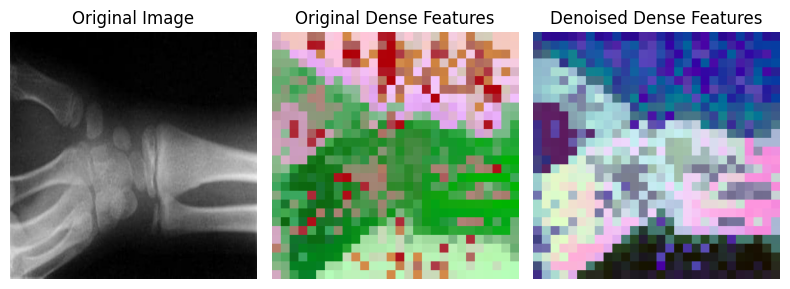

In [ ]:
# visualize image, original dense featurese, and denoised dense features
ori_img_trans = transforms.Compose([
                            transforms.Resize(resolution, interpolation=transforms.InterpolationMode.BICUBIC),
                            transforms.CenterCrop(resolution),
                            ])
ori_img_tensor = ori_img_trans(ori_img)

# Umap for original dense featurese
original_feat_umap = feature_umap(original_dense[0], num_patches)
# print(original_feat_umap.shape)

# Umap for denoised dense features
denoised_feat_umap = feature_umap(denoised_dense[0], num_patches)
# print(denoised_feat_umap.shape)

# Visualization
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 24))
axes = axes.flatten()

axes[0].imshow(ori_img_tensor)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(original_feat_umap)
axes[1].set_title("Original Dense Features")
axes[1].axis('off')

axes[2].imshow(denoised_feat_umap)
axes[2].set_title("Denoised Dense Features")
axes[2].axis('off')

plt.tight_layout()
plt.show()